In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import descartes
import rtree
import matplotlib.pyplot as plt
import scipy.stats as sci
import seaborn as sns
import mapclassify
import statsmodels.api as sm
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

## I. Demolition Data and Connect to Census Tracts

AxesSubplot(0.125,0.194852;0.775x0.615297)


,address,parcel_id,contractor,price,funding_so,demolition,commercial,council_di,neighborho,emergency_,street_num,street_dir,street_nam,street_typ,block_rang,ObjectId,geometry,year
0,14877 Wilfred,21011199.,Salenbien Trucking & Excavating Inc.,20258.4,HHF,2018-04-11T00:00:00.000Z,No,4,Outer Drive-Hayes,No,14877,None,WILFRED,St,14700-14899 Wilfred St,1,POINT (-82.96762 42.41941),2018
1,19960 Mccormick,21080155.,"Adamo Group, Inc.",16019.2,Non-HHF,2019-11-26T00:00:00.000Z,No,4,Moross-Morang,No,19960,None,MCCORMICK,St,19900-20199 McCormick St,2,POINT (-82.93697 42.42875),2019


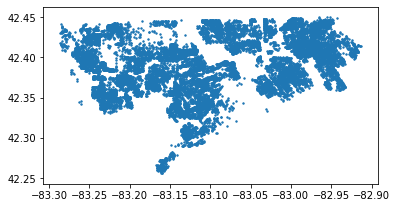

In [3]:
#Import demolition data
demos=gpd.read_file('Completed_Residential_Demolitions/Completed_Residential_Demolitions.shp')
demos['year']=pd.to_datetime(demos['demolition']).apply(lambda x: x.year.astype(int))
print(demos.plot(markersize=2))
demos.head(2) #look at it

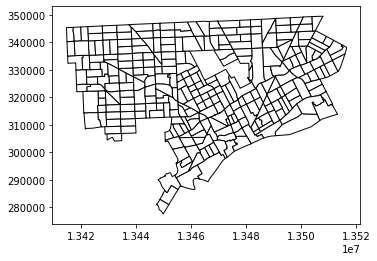

In [10]:
#Import Michigan tract shapes and align CRS's between tracts and demolition data
michigan=gpd.read_file('Census_Tracts_Census_2010_Michigan/Census_Tracts_Census_2010_Michigan.shp')
demos=demos.to_crs(michigan.crs)

#Limit Michigan data to just Detroit tracts
detroit=michigan[michigan['City'] == 'Detroit'].reset_index()
detroit.plot(color='white', edgecolor='black')

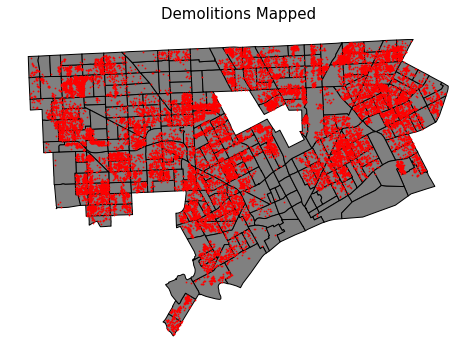

In [5]:
#overlay demolitions and tracts on same map
fig=plt.subplots(figsize=(9,6))

ax1=plt.subplot()
detroit.plot(color='grey', edgecolor='black', figsize=(9,6), ax=ax1)
demos.plot(ax=ax1, markersize=.5, marker='o', color='red')
plt.title('Demolitions Mapped', fontdict={'fontsize' : 15})
ax1.set_axis_off()

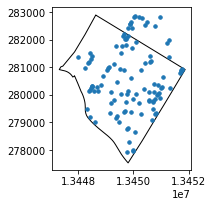

In [6]:
#Peak at one census tract
base=detroit[detroit['OBJECTID'] == 11].plot(color='white', edgecolor='black', figsize=(3,3))
xmin,ymin,xmax,ymax=detroit[detroit['OBJECTID'] == 11].total_bounds
demos.cx[xmin:xmax,ymin:ymax].plot(ax=base, markersize=12)

In [7]:
#Spatial Join them together so that I have demoltions by tract
demo_tract=gpd.sjoin(left_df=detroit, right_df=demos, how='left', op='contains')
demo_tract.head()

,index,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,...,council_di,neighborho,emergency_,street_num,street_dir,street_nam,street_typ,block_rang,ObjectId,year
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,6.0,Boynton,No,3795.0,None,BASSETT,St,3700-3851 S Bassett St,19973.0,2019.0
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,6.0,Boynton,No,3787.0,None,BASSETT,St,3700-3851 S Bassett St,19974.0,2015.0
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,6.0,Boynton,No,3615.0,None,ETHEL,St,3500-3699 S Ethel St,19277.0,2015.0
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,6.0,Boynton,No,3461.0,None,BASSETT,St,3400-3549 S Bassett St,20042.0,2019.0
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,6.0,Boynton,No,3428.0,None,ETHEL,St,3300-3499 S Ethel St,13707.0,2016.0


In [8]:
#Calculate demolitions by tract
demolition_by_tract=demo_tract[['OBJECTID', 'STATEFP10','COUNTYFP10','TRACTCE10']].groupby(['STATEFP10','COUNTYFP10','TRACTCE10']).count().reset_index()
demolition_by_tract.columns = ['statefp','countyfp','tractfp','demolitions']
demolition_by_tract['tractid']=demolition_by_tract['statefp'] + demolition_by_tract['countyfp'] + demolition_by_tract['tractfp']

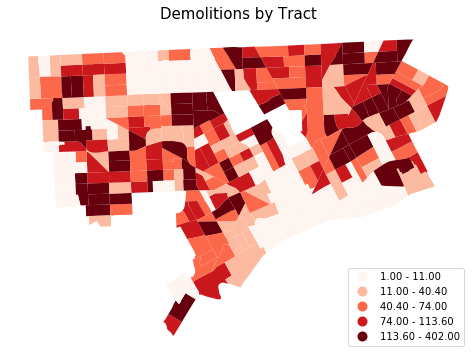

In [9]:
#Chloropleth map of demolitions by tract
gdf_tractdemos=pd.merge(detroit,demolition_by_tract, how='left', left_on='TRACTCE10', right_on='tractfp')
gdf_tractdemos=gdf_tractdemos.set_geometry('geometry')
fig, ax=plt.subplots(1, figsize=(9,6))
ax=gdf_tractdemos.plot(ax=ax,column='demolitions', cmap='Reds', edgecolor=None,legend=True, scheme='quantiles', legend_kwds={'loc' : 'lower right'})
plt.title('Demolitions by Tract', fontdict={'fontsize' : 15})
ax.set_axis_off()
fig.savefig('demosbytract.png')

## II. Import blight by tract data for Detroit
https://portal.datadrivendetroit.org/datasets/census-tracts-census-2010-michigan/data
https://portal.datadrivendetroit.org/datasets/motor-city-mapping-winter-2013-14-certified-results
https://portal.datadrivendetroit.org/datasets/motor-city-mapping-certified-results-winter-2013-14-census-tract-aggregation/data

In 2013, a committee on blight in Detroit worked with a non-profit to survey all parcels in the city and highlight the locations of all abandoned buildings that were suggested for demolitions. The graph at the bottom of the section measures the number of suggested demolitions per census tract against the actual number. There is a positive relationshp, and the amount of blight in a tract explains 65% of the total demolitions, which suggests there are other factors that determine the amount of demolitions in a neighborhood.

In [15]:
#This import contains the total number of unoccupied residential structures by tract
blight=pd.read_csv('MotorCityMapping_Blight.csv', dtype={'GEOID10':'str'})
blight.shape

(297, 108)

In [12]:
#This just limits the blight dataset
blight_lim=blight[['OBJECTID','GEOID10','ResStruct_Unoccupied']]

In [13]:
#Merge abandoned structures by tract to demolitions by tract
tract_demo_blight=pd.merge(demolition_by_tract, blight_lim, how='left', left_on='tractid',right_on='GEOID10')
tract_demo_blight['ResStruct_Unoccupied'] = tract_demo_blight['ResStruct_Unoccupied'].fillna(0)

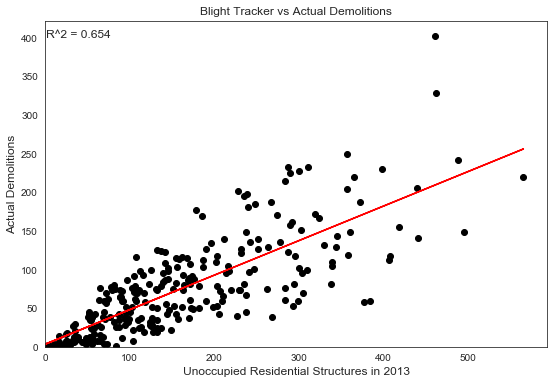

In [14]:
#Scatter plot of demolitions by tract against abandoned residential structures by tract
sns.set_style('white')
fig=plt.subplots(figsize=(9,6))

X=tract_demo_blight['ResStruct_Unoccupied']
Y=tract_demo_blight['demolitions']
slope, intercept, r_value, p_value, std_err=sci.linregress(X,Y)
Yhat=intercept + slope*X


plt.subplot()
plt.scatter(X,Y,color='black')
plt.plot(X,Yhat, color='red')
plt.text(1,400, 'R^2 = '+str(round(r_value**2,3)), fontsize=12)
plt.title('Blight Tracker vs Actual Demolitions', fontsize=12)
plt.xlabel('Unoccupied Residential Structures in 2013', fontsize=12)
plt.ylabel('Actual Demolitions', fontsize=12)
plt.xlim(0,)
plt.ylim(0,)
plt.savefig('abandonedunits.png')

## III. Import Detroit Redlining Maps and Blight Data
This tests a hypothesis suggested by Dr. Kim in places that were formerly redlined because they were segregated and suffered disinvestment and will continue to be disproportionately poor today. The graph below only finds modest support for this. Areas with the highest grade have substantially less demolition, but the next three grades all have similar amounts.

In [16]:
#Import redline shapefiles for Detroit
redline=gpd.read_file('/Users/petermannino/Documents/School/Classes/Land Use and Housing/Project/Demolitions/redlin_detroit1939/cartodb-query.shp')

In [17]:
#Import the status of each parcel in the city as shapefile - to limit to all abandoned units
trkrpoints=gpd.read_file('Motor_City_Mapping_Winter_201314_Certified_Results')

In [63]:
#convert parcel polygons to points
trkrpoints['point'] = trkrpoints['geometry'].centroid
trkrpoints=trkrpoints.set_geometry('point')

In [32]:
#align CRS
redline=redline.to_crs(demos.crs)
print(detroit.crs)
print(redline.crs)
print(demos.crs)

{'init': 'epsg:2898'}
{'init': 'epsg:2898'}
{'init': 'epsg:2898'}


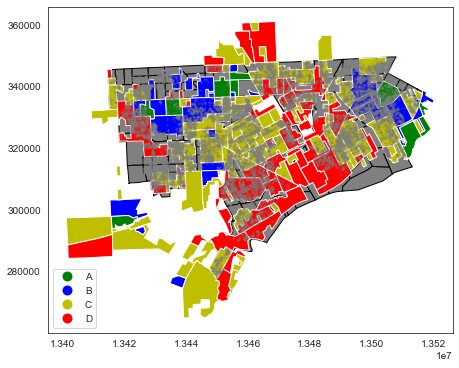

In [19]:
#A terrible looking map

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
detroit=detroit.set_geometry('geometry')
cmap=ListedColormap(['g','b','y','r'])
minx,miny,maxx,maxy=demos.total_bounds
base1=detroit.plot(color='gray', edgecolor='black', figsize=(9,6))
base=redline.cx[minx:maxx,miny:maxy].plot(ax=base1,column='holc_grade', legend=True, cmap=cmap, figsize=(9,6), legend_kwds={'loc':'lower left'})
demos.plot(ax=base1, markersize=2, alpha=.2, color='grey')

In [28]:
#demolitions by holc_grade
red_demo=gpd.sjoin(demos,redline, how='left', op='within')
red_demo_summary=red_demo[['holc_grade', 'parcel_id']].groupby('holc_grade').count().reset_index().rename(columns={'parcel_id': 'demolitions'})

In [29]:
#total area of each grade
redline['area'] = redline['geometry'].area
redline_areas=pd.DataFrame(redline.groupby('holc_grade')['area'].sum()).reset_index()

In [30]:
#Demos per million square feet in each grade
demo_area=pd.merge(red_demo_summary,redline_areas, how='inner')
demo_area['demos_per_area'] = demo_area['demolitions']/demo_area['area']*1000000
demo_area.head()

,holc_grade,demolitions,area,demos_per_area
0,A,472,3.612610e+08,1.306535
1,B,2919,8.110285e+08,3.599134
2,C,9610,2.937748e+09,3.271213
3,D,4940,1.634750e+09,3.021869


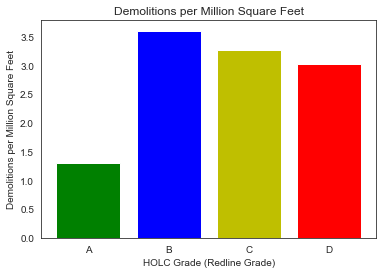

In [31]:
fig,ax=plt.subplots()

plt.subplot()
plt.bar(demo_area.holc_grade,demo_area.demos_per_area, color=['g','b','y','r'])
plt.title('Demolitions per Million Square Feet')
plt.xlabel('HOLC Grade (Redline Grade)')
plt.ylabel('Demolitions per Million Square Feet')

fig.savefig('redline_demo.png', bbox_inches='tight')

## IV. Import Census data via NHGIS

Connect census data to explore relationships between demographics in a tract and subsequent demolition.

In [34]:
nhgis=pd.read_csv('nhgis0011_csv/nhgis0011_ds239_20185_2018_tract.csv', dtype={'STATEA' : str, 'COUNTYA' : str, 'TRACTA' : str}, encoding='latin-1')

In [35]:
nhgis['pct_black'] = nhgis.AJWVE004/nhgis.AJWVE001*100
nhgis['med_household_inc'] = nhgis.AJZAE001
nhgis['vacancy_rate'] = nhgis.AJ1TE003/nhgis.AJ1TE001*100
nhgis['median_house_value'] = nhgis.AJ3QE001
nhgis['ownershiprate'] = nhgis.AJ1UM002/nhgis.AJ1UM001*100

In [36]:
nhgis_detroit=nhgis[(nhgis['STATE'] == 'Michigan') & (nhgis['COUNTY'] == 'Wayne County')]

In [37]:
demo_blight_nhgis=pd.merge(tract_demo_blight, nhgis_detroit, how='left', left_on='tractfp', right_on='TRACTA')

In [44]:
dem_rate=demo_blight_nhgis[['pct_black', 'med_household_inc',
       'vacancy_rate', 'median_house_value', 'ownershiprate', 'tractfp','demolitions','ResStruct_Unoccupied']]

In [45]:
#table with demographics, demolitions and abandoned units
detroit_demo=pd.merge(detroit,dem_rate,how='left',left_on='TRACTCE10',right_on='tractfp')

## V. Import Hardest Hit Fund Areas

In [56]:
hhf=gpd.read_file('Hardest_Hit_Fund_Areas_with_Expansion')

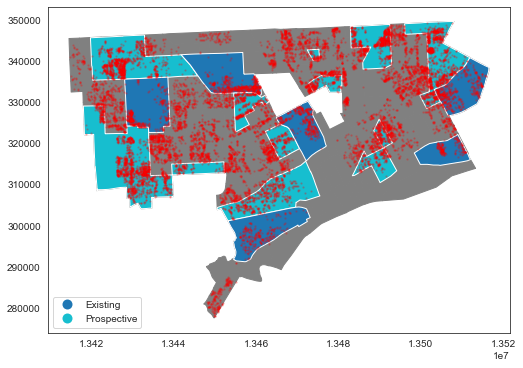

In [58]:
#Map HHF areas and demolitions
demos=demos.to_crs(detroit_demo.crs)
base1=detroit_demo.plot(color='grey', figsize=(9,6), edgecolor='grey')
hhf.plot(column='Area_Type', ax=base1, legend=True)
demos[demos['funding_so'] == 'HHF'].plot(ax=base1, markersize=2, alpha=.2, color='red')

In [60]:
#identify the tracts within HHF areas
detroit_demo['centeroid'] = detroit_demo.centroid
detroit_demo=detroit_demo.set_geometry('centeroid')
hhf_tract=gpd.sjoin(detroit_demo,hhf, how='left', op='within')
detroit_demo=detroit_demo.set_geometry('geometry')
hhf_tract.head()


,index,OBJECTID_left,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,...,tractfp,demolitions,ResStruct_Unoccupied,centeroid,index_right,OBJECTID_right,Shape_Leng,Id,Name,Area_Type
0,823,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,...,524800,98,112.0,POINT (13449550.353 280430.356),NaN,NaN,NaN,NaN,NaN,NaN
1,850,38,26,163,521900,26163521900,5219,Census Tract 5219,G5020,S,...,521900,12,39.0,POINT (13471003.345 312564.876),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
2,851,39,26,163,521800,26163521800,5218,Census Tract 5218,G5020,S,...,521800,1,0.0,POINT (13473535.898 311044.599),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
3,852,40,26,163,521500,26163521500,5215,Census Tract 5215,G5020,S,...,521500,12,37.0,POINT (13472198.367 307648.719),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
4,853,41,26,163,521400,26163521400,5214,Census Tract 5214,G5020,S,...,521400,1,14.0,POINT (13473146.034 305375.739),NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
#generate smaller table of tracts within hhf
hhf_tract_data=hhf_tract[['TRACTCE10','GEOID10','Name']]

# VI. Create Maps of Demoltions, Abandon Houses, and Demographics

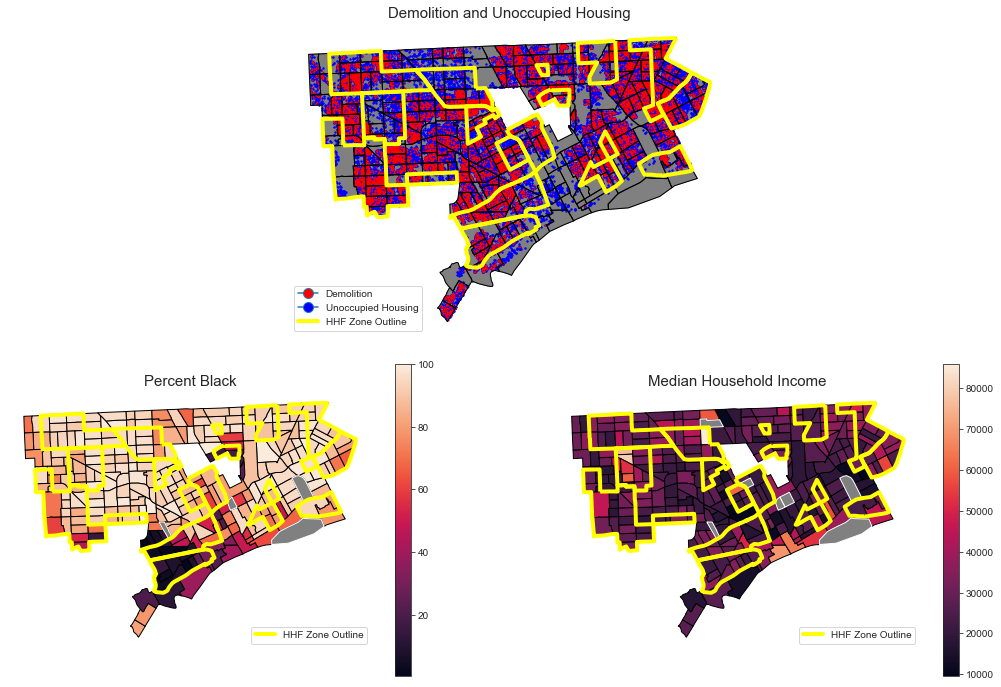

In [64]:
#overlay demolitions and tracts on same map
legend_element = [Line2D([0],[0],markerfacecolor='red', marker='o', label='Demolition', markersize=10),
                 Line2D([0],[0],markerfacecolor='blue', marker='o', label='Unoccupied Housing', markersize=10),
                 Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)]

detroit_demo=detroit_demo.set_geometry('geometry')
fig=plt.figure(figsize=(18,12))
spec=gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

ax1 = fig.add_subplot(spec[0:2, 0:])

detroit_demo.plot(color='grey', edgecolor='grey', figsize=(9,6), ax=ax1)
trkrpoints[trkrpoints['Occupancy'] == 'unoccupied'].plot(color='blue', markersize=2, ax=ax1)
demos.plot(ax=ax1, markersize=.5, marker='o', color='red')
detroit_demo.plot(facecolor='none', edgecolor='black', figsize=(9,6), ax=ax1)
hhf.plot(ax=ax1, edgecolor='yellow', linewidth=4, facecolor='none')
plt.title('Demolition and Unoccupied Housing', fontdict={'fontsize' : 15})
ax1.set_axis_off()
ax1.legend(handles=legend_element, loc='best')

ax2 = fig.add_subplot(spec[-2:, 0])
detroit_demo[detroit_demo['pct_black'].notna()].plot(column='pct_black',edgecolor='black', figsize=(9,6),legend=True, ax=ax2)
detroit_demo[detroit_demo['pct_black'].isna()].plot(color='grey', ax=ax2)
hhf.plot(ax=ax2, edgecolor='yellow', linewidth=4, facecolor='none')
plt.title('Percent Black',fontdict={'fontsize' : 15})
ax2.set_axis_off()
plt.legend(handles=[Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)], loc='lower right')


ax3 = fig.add_subplot(spec[-2:, 1])
detroit_demo[(detroit_demo['med_household_inc'].notna()) & (detroit_demo['med_household_inc']<100000)].plot(column='med_household_inc',edgecolor='black', figsize=(9,6),legend=True, ax=ax3)
detroit_demo[(detroit_demo['med_household_inc'].isna()) | (detroit_demo['med_household_inc']>100000)].plot(color='grey', ax=ax3)
hhf.plot(ax=ax3, edgecolor='yellow', linewidth=4, facecolor='none')
plt.title('Median Household Income',fontdict={'fontsize' : 15})
ax3.set_axis_off()
plt.legend(handles=[Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)], loc='lower right')


plt.gcf().savefig('Demo_Demos.png', bbox_inches='tight')

## VII. Regression Analysis

In [70]:
#Add HHF as a dummy variable to the data table
demo_blight_nhgis_hhf=pd.merge(demo_blight_nhgis, hhf_tract_data, how='left', left_on='GEOID10',right_on='GEOID10')
demo_blight_nhgis_hhf['hhf_dummy']=demo_blight_nhgis_hhf['Name'].notnull().astype(int)

In [72]:
#Create reg data by dropping NA's
demo_blight_nhgis_hhf_regdat=demo_blight_nhgis_hhf[['GEOID10','demolitions','ResStruct_Unoccupied','med_household_inc','pct_black','median_house_value','hhf_dummy']].dropna()

In [75]:
#Regression with just demographics and hhf areas
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
#xs['hhf_pctblk'] = xs['pct_black']*xs['hhf_dummy']
#xs['hhf_medinc'] = xs['med_household_inc']*xs['hhf_dummy']
ys=demo_blight_nhgis_hhf_regdat['demolitions']
xs=sm.add_constant(xs)
models=sm.OLS(ys,xs).fit(cov_type='HC1')
print(models.summary())

#plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(models.summary()), {'fontsize': 16}, fontproperties = 'monospace') # approach improved by OP -> monospace!
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('output.png', bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:            demolitions   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     65.97
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           6.63e-39
Time:                        15:09:15   Log-Likelihood:                -1377.6
No. Observations:                 276   AIC:                             2765.
Df Residuals:                     271   BIC:                             2783.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.4755 

In [76]:
# with interaction terms between demographics and hhf areas
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
xs['hhf_pctblk'] = xs['pct_black']*xs['hhf_dummy']
xs['hhf_medinc'] = xs['med_household_inc']*xs['hhf_dummy']
ys=demo_blight_nhgis_hhf_regdat['demolitions']
xs=sm.add_constant(xs)
models=sm.OLS(ys,xs).fit(cov_type='HC1')
print(models.summary())

#plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(models.summary()), {'fontsize': 16}, fontproperties = 'monospace') # approach improved by OP -> monospace!
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('output.png', bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:            demolitions   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     48.29
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           5.08e-40
Time:                        15:09:35   Log-Likelihood:                -1373.5
No. Observations:                 276   AIC:                             2761.
Df Residuals:                     269   BIC:                             2786.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   22.9696 

/Users/petermannino/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/petermannino/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
#standardized regression
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
xs_standard=xs.apply(sci.zscore)
#xs['hhf_pctblk'] = xs['pct_black']*xs['hhf_dummy']
#xs['hhf_medinc'] = xs['med_household_inc']*xs['hhf_dummy']
ys=demo_blight_nhgis_hhf_regdat['demolitions']
ys_standard=pd.DataFrame(ys).apply(sci.zscore)
#xs=sm.add_constant(xs)
models_standard=sm.OLS(ys_standard,xs_standard).fit(cov_type='HC1')
print(models_standard.summary())

                                 OLS Regression Results                                
Dep. Variable:            demolitions   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              66.21
Date:                Mon, 17 Aug 2020   Prob (F-statistic):                    4.73e-39
Time:                        15:13:21   Log-Likelihood:                         -232.27
No. Observations:                 276   AIC:                                      472.5
Df Residuals:                     272   BIC:                                      487.0
Df Model:                           4                                                  
Covariance Type:                  HC1                                                  
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------